In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession as spark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import time
import re

In [2]:
def runExperiment(inputUri, outputUri, appName, numCores):
    # fixed memory size
    sparkSession = SparkSession\
            .builder\
            .master('spark://192.168.2.25:7077') \
            .appName(appName)\
            .config("spark.executor.cores", 2)\
            .config("spark.executor.memory", "2g")\
            .config("spark.executor.instances", 8)\
            .config('spark.shuffle.service.enabled', False)\
            .config('spark.dynamicAllocation.executorIdleTimeout','30s')\
            .config('spark.cores.max', numCores)\
            .config('spark.driver.port',9998)\
            .config('spark.blockManager.port',10005)\
            .config('spark.mongodb.input.uri', inputUri)\
            .config('spark.mongodb.output.uri', outputUri)\
            .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
            .getOrCreate()
            # .config('spark.dynamicAllocation.enabled', True)\
            # .config('spark.dynamicAllocation.shuffleTracking.enabled',True)\    
    t = time.time()
    df = sparkSession.read.format('com.mongodb.spark.sql.DefaultSource').load()
    df = df.select('_id','year','loudness','tempo','artist_hotttnesss','beats_confidence','duration','artist_latitude','artist_longitude','key_confidence')
    df = df.withColumn('y_label', f.when(f.col('artist_hotttnesss') > 0.5, 1).otherwise(0))
    features = ['year', 'loudness', 'tempo', 'duration', 'key_confidence']
    label = 'y_label'

    assembler = VectorAssembler()\
            .setInputCols(features)\
            .setOutputCol('vectorized_features')
    df = assembler.transform(df)
    train, test = df.randomSplit([0.7, 0.3], seed = 2018)
    lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'y_label', maxIter=10)
    lrModel = lr.fit(train)
    d = time.time()
    duration = d - t

    sparkSession.stop()

    return duration

## Strong Scaling with 1.5 million data

In [10]:
numIterations = 10

## 2 cores

In [4]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '2 cores'
numCores = 2

resultsStrong2 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong2 = np.mean(resultsStrong2)
print(f'{resultsStrong2}, Avg: {avgStrong2}')

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cd630774-b1cd-4b1e-bd6c-b18663bbc3ea;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;2.4.2 in central
	found org.mongodb#mongo-java-driver;3.12.5 in central
:: resolution report :: resolve 290ms :: artifacts dl 7ms
	:: modules in use:
	org.mongodb#mongo-java-driver;3.12.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;2.4.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0  

[54.12780952453613, 54.30810499191284, 51.01313614845276, 51.12658333778381, 50.83088135719299, 49.678338289260864, 49.3385534286499, 46.9016318321228, 48.48854422569275, 50.77112889289856], Avg: 50.65847120285034


## 4 cores

In [11]:
input_uri_4c="mongodb://127.0.0.1/million_songs.songsOHalfM"
output_uri_4c="mongodb://127.0.0.1/million_songs.songsOHalfM"
appName = '4 cores'
numCores = 4

resultsStrong4 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong4 = np.mean(resultsStrong4)
print(f'{resultsStrong4}, Avg: {avgStrong4}')

[40.64188194274902, 45.636130571365356, 41.60646057128906, 39.98821496963501, 42.637221574783325, 40.0330810546875, 42.77509570121765, 45.410189628601074, 41.83036136627197, 42.19762206077576], Avg: 42.27562594413757


## 8 cores

In [5]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '8 cores'
numCores = 8

resultsStrong8 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong8 = np.mean(resultsStrong8)
print(f'{resultsStrong8}, Avg: {avgStrong8}')

[23.055397748947144, 25.69982671737671, 23.370848178863525, 24.628153085708618, 24.438987970352173, 24.025280237197876, 23.78170394897461, 24.343316316604614, 23.182403326034546, 23.501858472824097], Avg: 24.00277760028839


## 12 cores

In [6]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '12 cores'
numCores = 12

resultsStrong12 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong12 = np.mean(resultsStrong12)
print(f'{resultsStrong12}, Avg: {avgStrong12}')

[23.433969497680664, 24.37294030189514, 24.26874804496765, 21.08976435661316, 24.488106727600098, 23.192458629608154, 22.91324520111084, 25.277400970458984, 23.605341911315918, 22.447609663009644], Avg: 23.508958530426025


## 16 cores

In [7]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '16 cores'
numCores = 16
numIterations = 1

resultsStrong16 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgStrong16 = np.mean(resultsStrong16)
print(f'{resultsStrong16}, Avg: {avgStrong16}')

[26.460996866226196], Avg: 26.460996866226196


## Results

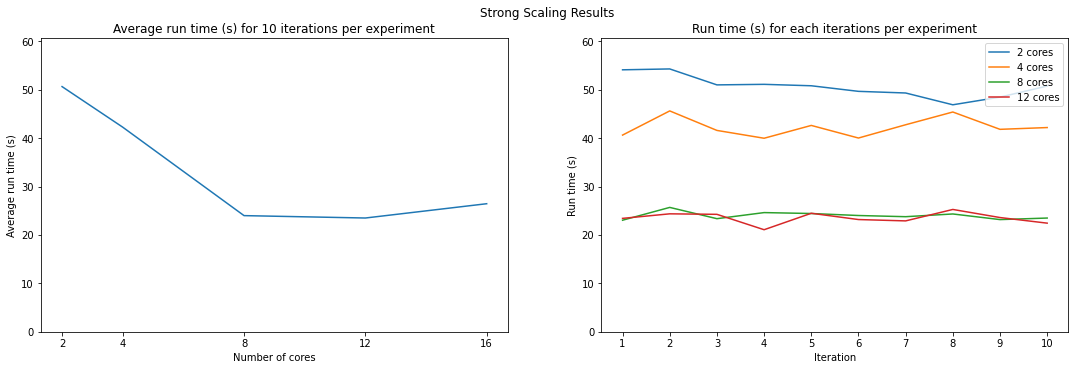

In [13]:
def printResults(results, labels, avgs, numIterations):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Strong Scaling Results')
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

    xAxis = [int(re.sub("[^0-9]", "", cores)) for cores in labels]
    yAxis = [avg for avg in avgs]

    ax1.plot(xAxis,yAxis)
    ax1.set_title('Average run time (s) for 10 iterations per experiment')
    ax1.set_xticks(xAxis)
    ax1.set_ylim(0,np.max(yAxis)+10)
    ax1.set_xlabel('Number of cores')
    ax1.set_ylabel('Average run time (s)')

    xAxis = range(1,numIterations+1)

    for i, result in enumerate(results):
        ax2.plot(xAxis, result, label=labels[i])
        
    ax2.set_title('Run time (s) for each iterations per experiment')
    ax2.set_xticks(xAxis)
    ax2.set_ylim(0,np.max(yAxis)+10)
    plt.legend(loc="upper right")
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Run time (s)')
    
    plt.show()
    
printResults([resultsStrong2, resultsStrong4, resultsStrong8, resultsStrong12],
             ['2 cores', '4 cores', '8 cores', '12 cores', '16 cores'],
             [avgStrong2, avgStrong4, avgStrong8, avgStrong12, avgStrong16], numIterations)

# I separate the reading part and calculation part in “g16_experiments-Copy1.ipynb”, the error is gone, and if you compare with the reading time, it basically doesn't change no matter how many cores

## Weak Scaling

In [14]:
numIterations = 10

## 250000 songs, 2 cores

In [15]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsQuarterM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsQuarterM'
appName = '250000 data for 2 cores'
numCores = 2

resultsWeak2 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak2 = np.mean(resultsWeak2)
print(f'{resultsWeak2}, Avg: {avgWeak2}')

[37.336228132247925, 18.96622133255005, 17.498624563217163, 16.493058919906616, 17.046579599380493, 18.074819803237915, 19.301040410995483, 18.15777325630188, 16.798214435577393, 18.04022765159607], Avg: 19.771278810501098


## 500000 songs, 4 cores

In [16]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsHalfM'
appName = '500000 data for 4 cores'
numCores = 4

resultsWeak4 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak4 = np.mean(resultsWeak4)
print(f'{resultsWeak4}, Avg: {avgWeak4}')

22/03/19 21:47:29 WARN BlockManager: Asked to remove block broadcast_18, which does not exist
22/03/19 21:50:17 WARN NioEventLoop: Selector.select() returned prematurely 512 times in a row; rebuilding Selector io.netty.channel.nio.SelectedSelectionKeySetSelector@bbbed12.
22/03/19 21:50:17 WARN NioEventLoop: Selector.select() returned prematurely 512 times in a row; rebuilding Selector io.netty.channel.nio.SelectedSelectionKeySetSelector@3be8d8e6.


[54.44793701171875, 27.234177112579346, 23.626288652420044, 23.36302947998047, 22.312450885772705, 23.992677211761475, 23.699826955795288, 23.597098112106323, 22.43218183517456, 22.38236665725708], Avg: 26.708803391456605


## 1000000 songs, 8 cores

In [18]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOneM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOneM'
appName = '1000000 data for 8 cores'
numCores = 8

resultsWeak8 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak8 = np.mean(resultsWeak8)
print(f'{resultsWeak8}, Avg: {avgWeak8}')

[28.477569580078125, 25.189229488372803, 25.636915922164917, 28.330768585205078, 31.201080083847046, 29.99726963043213, 30.308520555496216, 24.341835260391235, 30.495498180389404, 25.448400497436523], Avg: 27.94270877838135


## 1500000 songs, 12 cores

In [20]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '1500000 data for 12 cores'
numCores = 12

resultsWeak12 = [runExperiment(inputUri, outputUri, appName, numCores) for i in range(numIterations)]
avgWeak12 = np.mean(resultsWeak12)
print(f'{resultsWeak12}, Avg: {avgWeak12}')

[25.6029634475708, 25.25237774848938, 25.01112198829651, 23.043833255767822, 25.40808606147766, 23.762166738510132, 25.217485904693604, 24.340126514434814, 20.939072847366333, 23.33346915245056], Avg: 24.191070365905762


## Results

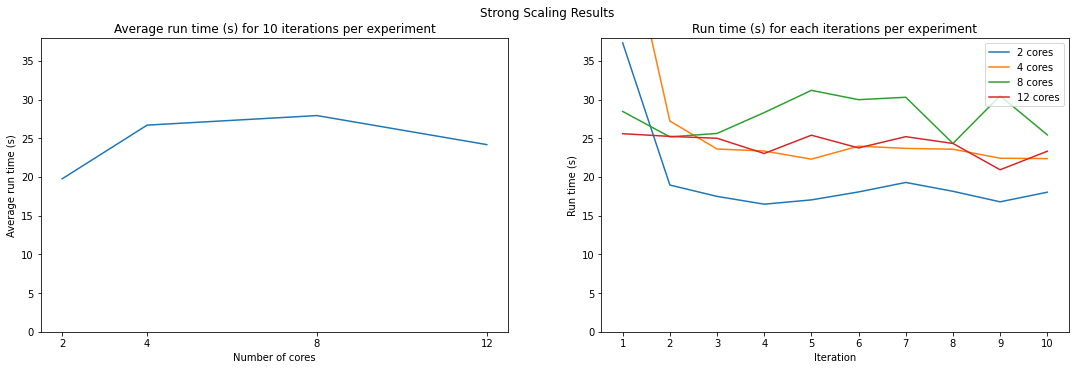

In [21]:
printResults([resultsWeak2, resultsWeak4, resultsWeak8, resultsWeak12],
             ['2 cores', '4 cores', '8 cores', '12 cores'],
             [avgWeak2, avgWeak4, avgWeak8, avgWeak12], numIterations)

## Horizontal scaling with 1.5 million data

## 4 workers 

In [24]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '1500000 data for 4 workers'
numCores = 12
resultsWeak12 = runExperiment(inputUri, outputUri, appName, numCores)
print(f'{resultsWeak12}')

24.89060139656067


## 5 workers

## 6 workers